# MAPPING CROSS CORRELATION LAG

In [15]:
from datetime import date, timedelta
from math import *
import os

from dateutil.relativedelta import relativedelta
import ipywidgets as widgets
from ipywidgets import fixed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from progressbar import ProgressBar
import rasterio as rio
from rasterio.windows import Window
import re
from tifffile import imsave
import time
import xarray as xr

Functions

In [2]:
def max_corr(datax, datay):
    
    crosscorr = []
    
    for lag in np.arange(-5,40,1):
        crosscorr.append(datax.corr(datay.shift(lag)))
        
        
    return ((crosscorr.index(max(crosscorr)) - 5), max(crosscorr))


def min_corr(datax, datay):
    
    crosscorr = []
    
    for lag in np.arange(-8,8,1):
        crosscorr.append(datax.corr(datay.shift(lag)))
        
        
    return ((crosscorr.index(min(crosscorr)) - 8), min(crosscorr))

In [3]:
def filename_to_gregorian(filename: str):
    '''Converts filename to date tuple'''

    # seeking for date pattern in the filename
    pattern = re.search(r'\d{4}j\d{3}', filename).group()

    # getting year and DOY
    year = int(pattern[0:4])
    day = int(pattern[5:8])
    
    # converting DOY to gregorian
    gregorian = date(year, 1, 1) + timedelta(day - 1)
    
    return gregorian

def gregorian_to_DOY(month: int, day:int):
    '''Converts gregorian date to DOY'''
    
    # we chose 2020 randomly because the year isn't taken into account
    DOY = (date(2020,month,day) - date(2020, 1, 1)).days + 1
    return DOY

In [4]:
def lta_ts(index: pd.DatetimeIndex, ts: pd.Series):
    
    lta =  lta_dict(index, ts)    
    lta_list = []


    for i,x in enumerate(index):

        key = '{}-{}'.format(x.month, x.day)
        lta_list.append(lta[key])
        
    return lta_list

def anomaly(index: pd.DatetimeIndex, ts: pd.Series):
    
    lta =  lta_dict(index, ts)    
    anom = []


    for i,x in enumerate(index):

        key = '{}-{}'.format(x.month, x.day)
        anom.append((ts[i] - lta[key])/np.std(ts))
        
    return anom

def lta_dict(index: pd.DatetimeIndex, ts: pd.Series):
    
    lta_begin = date(2002,7,1)
    lta_end = date(2018,7,1)

    mondays = {'{}-{}'.format(x.month, x.day) for x in index}

    # initialize the dicts
    lta_dict = {}

    for md in mondays:

        lta = 0 
        nb = 0

        month, day = md.split('-')
        month, day = (int(month), int(day))

        # converting gregorian to DOY
        DOY = gregorian_to_DOY(month = month, day = day)

        for ix, date_sel in enumerate(index):

            # only select the dates in LTA period
            if date_sel < lta_begin or date_sel > lta_end:
                continue

            DOYsel = gregorian_to_DOY(month = date_sel.month, day = date_sel.day)

            if DOYsel == DOY:
                lta += ts[ix]
                nb += 1


        # add to LTA dict
        lta_dict[md] = lta/nb
        
    return lta_dict

**Downloading data**

NDVI

In [5]:
ndvi = ['NDVI/'+ x for x in os.listdir('NDVI')][-400:]
rasters = []

dates = pd.DatetimeIndex([filename_to_gregorian(x) for x in ndvi])

#progressbar
pbar = ProgressBar()

for rt in pbar(ndvi):   
    with rio.open(rt) as src:
        rasters.append(src.read(1))

ndvi = xr.DataArray(rasters,
                dims=('time','lat','lon'),
                coords={'time': dates})

100% |########################################################################|


TDA

In [6]:
tda = ['TDA/'+ x for x in os.listdir('TDA')][-400:]
rasters = []

#progressbar
pbar = ProgressBar()

for rt in pbar(tda):   
    with rio.open(rt) as src:           
        rasters.append(src.read(1))

tda = xr.DataArray(rasters,
                dims=('time','lat','lon'),
                coords={'time': dates})


100% |########################################################################|


**Calculating lags**

NDVI and TDA

**2,5 hours**

In [7]:
start_time = time.time()

N = 5

ndvi_tda_max = np.zeros((ceil(len(ndvi.lat.values)/N), ceil(len(ndvi.lon.values)/N)))
ndvi_tda_min = np.zeros((ceil(len(ndvi.lat.values)/N), ceil(len(ndvi.lon.values)/N)))

ndvi_tda_max_val = np.zeros((ceil(len(ndvi.lat.values)/N), ceil(len(ndvi.lon.values)/N)))
ndvi_tda_min_val = np.zeros((ceil(len(ndvi.lat.values)/N), ceil(len(ndvi.lon.values)/N)))

pbar = ProgressBar()
for i in pbar(np.arange(0,len(ndvi.lat.values),N)):
    for j in np.arange(0,len(ndvi.lon.values),N):
        
        df = pd.DataFrame(columns=['ndvi', 'tda'])

        #extracting time series
        df['ndvi'] = ndvi.sel(lat=slice(i,i+N), lon=slice(j,j+N)).mean(["lat", "lon"]).values
        df['tda'] = tda.sel(lat=slice(i,i+N), lon=slice(j,j+N)).mean(["lat", "lon"]).values

        #calculating lag
        ndvi_tda_max[int(i/N),int(j/N)], ndvi_tda_max_val[int(i/N),int(j/N)] = max_corr(df['ndvi'], df['tda'])
        ndvi_tda_min[int(i/N),int(j/N)], ndvi_tda_min_val[int(i/N),int(j/N)] = min_corr(df['ndvi'], df['tda'])  
        
print("--- %s seconds ---" % (time.time() - start_time))

--- 7852.358228683472 seconds ---


NDVI and TDA anomalies

**6 hours**

In [8]:
start_time = time.time()

N = 10

ndvi_tda_anom_max = np.zeros((ceil(len(ndvi.lat.values)/N), ceil(len(ndvi.lon.values)/N)))
ndvi_tda_anom_min = np.zeros((ceil(len(ndvi.lat.values)/N), ceil(len(ndvi.lon.values)/N)))

ndvi_tda_anom_max_val = np.zeros((ceil(len(ndvi.lat.values)/N), ceil(len(ndvi.lon.values)/N)))
ndvi_tda_anom_min_val = np.zeros((ceil(len(ndvi.lat.values)/N), ceil(len(ndvi.lon.values)/N)))

pbar = ProgressBar()
for i in pbar(np.arange(0,len(ndvi.lat.values),N)):
    for j in np.arange(0,len(ndvi.lon.values),N):
        
        df = pd.DataFrame(columns=['ndvi', 'tda', 'ndvi_anom', 'tda_anom'])

        #extracting time series
        df['ndvi'] = ndvi.sel(lat=slice(i,i+N), lon=slice(j,j+N)).mean(["lat", "lon"]).values
        df['tda'] = tda.sel(lat=slice(i,i+N), lon=slice(j,j+N)).mean(["lat", "lon"]).values
        
        df["ndvi_anom"] = anomaly(dates, df.ndvi)
        df["tda_anom"] = anomaly(dates, df.tda)

        #calculating lag
        ndvi_tda_anom_max[int(i/N),int(j/N)], ndvi_tda_anom_max_val[int(i/N),int(j/N)] = max_corr(df['ndvi_anom'], df['tda_anom'])
        ndvi_tda_anom_min[int(i/N),int(j/N)], ndvi_tda_anom_min_val[int(i/N),int(j/N)] = min_corr(df['ndvi_anom'], df['tda_anom'])

print("--- %s seconds ---" % (time.time() - start_time))

<ipython-input-4-0d30032c1857>:10: RuntimeWarning: invalid value encountered in double_scalars
  anom.append((ts[i] - lta[key])/np.std(ts))


--- 21700.773017406464 seconds ---


NDVI and TDA LTAs

**6 hours**

In [8]:
start_time = time.time()

N = 10

ndvi_tda_lta_max = np.zeros((ceil(len(ndvi.lat.values)/N), ceil(len(ndvi.lon.values)/N)))
ndvi_tda_lta_min = np.zeros((ceil(len(ndvi.lat.values)/N), ceil(len(ndvi.lon.values)/N)))

ndvi_tda_lta_max_val = np.zeros((ceil(len(ndvi.lat.values)/N), ceil(len(ndvi.lon.values)/N)))
ndvi_tda_lta_min_val = np.zeros((ceil(len(ndvi.lat.values)/N), ceil(len(ndvi.lon.values)/N)))

pbar = ProgressBar()
for i in pbar(np.arange(0,len(ndvi.lat.values),N)):
    for j in np.arange(0,len(ndvi.lon.values),N):
        
        df = pd.DataFrame(columns=['ndvi', 'tda', 'ndvi_lta', 'tda_lta'])

        #extracting time series
        df['ndvi'] = ndvi.sel(lat=slice(i,i+N), lon=slice(j,j+N)).mean(["lat", "lon"]).values
        df['tda'] = tda.sel(lat=slice(i,i+N), lon=slice(j,j+N)).mean(["lat", "lon"]).values
        
        df["ndvi_lta"] = lta_ts(dates, df.ndvi)
        df["tda_lta"] = lta_ts(dates, df.tda)

        #calculating lag
        ndvi_tda_lta_max[int(i/N),int(j/N)], ndvi_tda_lta_max_val[int(i/N),int(j/N)] = max_corr(df['ndvi_lta'], df['tda_lta'])
        ndvi_tda_lta_min[int(i/N),int(j/N)], ndvi_tda_lta_min_val[int(i/N),int(j/N)] = min_corr(df['ndvi_lta'], df['tda_lta'])

print("--- %s seconds ---" % (time.time() - start_time))

--- 12660.50069284439 seconds ---


## PLOTS

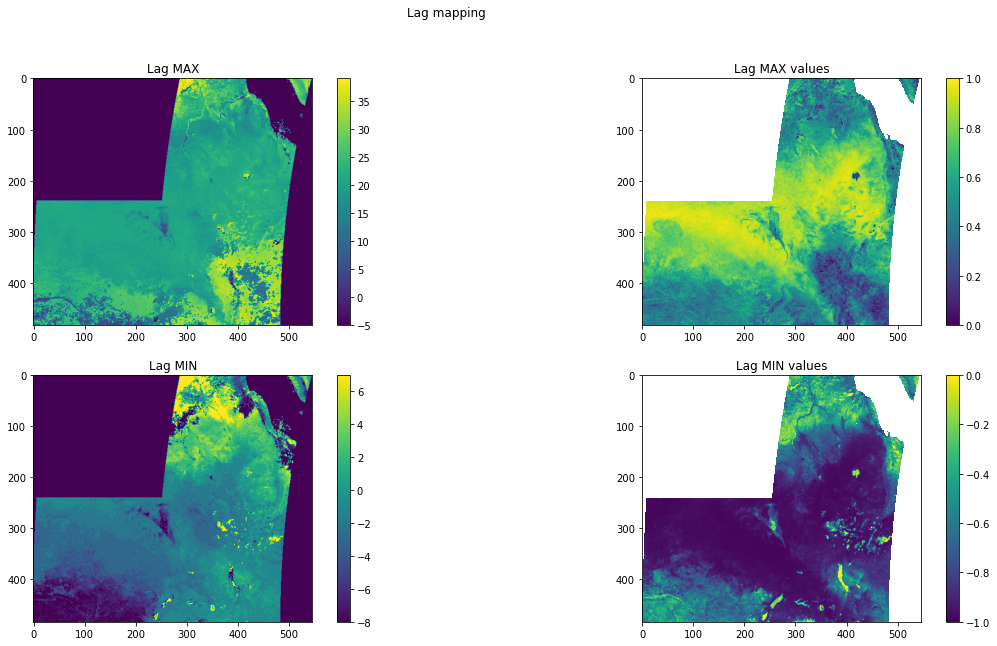

In [9]:
fig, axs  = plt.subplots(2,2,figsize=(20,10))

im0 = axs[0,0].imshow(ndvi_tda_max)
fig.colorbar(im0, ax = axs[0,0])
axs[0,0].set_title('Lag MAX');

im1 = axs[0,1].imshow(ndvi_tda_max_val)
fig.colorbar(im1, ax = axs[0,1])
im1.set_clim(0,1)
axs[0,1].set_title('Lag MAX values');

im2 = axs[1,0].imshow(ndvi_tda_min)
fig.colorbar(im2, ax = axs[1,0])
axs[1,0].set_title('Lag MIN');

im3 = axs[1,1].imshow(ndvi_tda_min_val)
fig.colorbar(im3, ax = axs[1,1])
im3.set_clim(0,-1)
axs[1,1].set_title('Lag MIN values');

fig.suptitle('Lag mapping');
fig.savefig('Lag_Mapping.png')

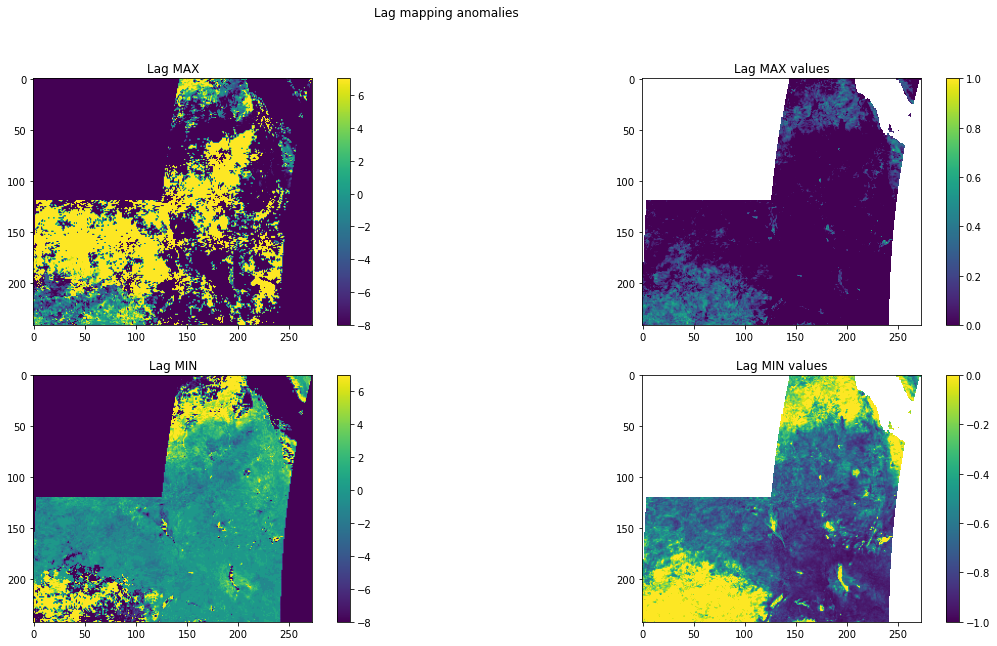

In [10]:
fig, axs  = plt.subplots(2,2,figsize=(20,10))

im0 = axs[0,0].imshow(ndvi_tda_anom_max)
fig.colorbar(im0, ax = axs[0,0])
axs[0,0].set_title('Lag MAX');

im1 = axs[0,1].imshow(ndvi_tda_anom_max_val)
fig.colorbar(im1, ax = axs[0,1])
im1.set_clim(0,1)
axs[0,1].set_title('Lag MAX values');

im2 = axs[1,0].imshow(ndvi_tda_anom_min)
fig.colorbar(im2, ax = axs[1,0])
axs[1,0].set_title('Lag MIN');

im3 = axs[1,1].imshow(ndvi_tda_anom_min_val)
fig.colorbar(im3, ax = axs[1,1])
im3.set_clim(0,-1)
axs[1,1].set_title('Lag MIN values');

fig.suptitle('Lag mapping anomalies');
fig.savefig('Lag_Mapping_anomalies.png')

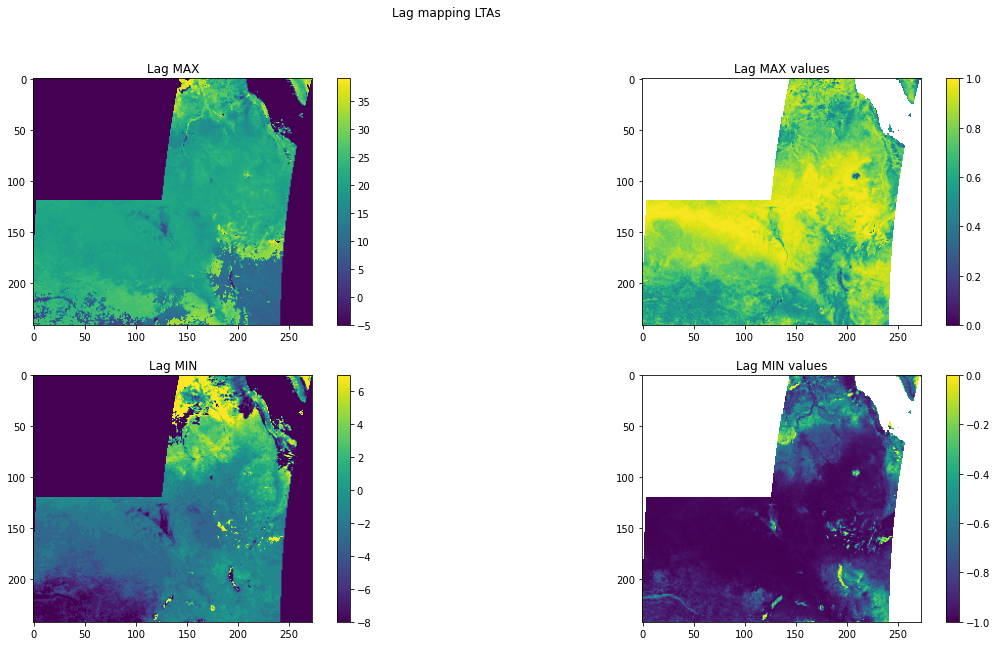

In [10]:
fig, axs  = plt.subplots(2,2,figsize=(20,10))

im0 = axs[0,0].imshow(ndvi_tda_lta_max)
fig.colorbar(im0, ax = axs[0,0])
axs[0,0].set_title('Lag MAX');

im1 = axs[0,1].imshow(ndvi_tda_lta_max_val)
fig.colorbar(im1, ax = axs[0,1])
im1.set_clim(0,1)
axs[0,1].set_title('Lag MAX values');

im2 = axs[1,0].imshow(ndvi_tda_lta_min)
fig.colorbar(im2, ax = axs[1,0])
axs[1,0].set_title('Lag MIN');

im3 = axs[1,1].imshow(ndvi_tda_lta_min_val)
fig.colorbar(im3, ax = axs[1,1])
im3.set_clim(0,-1)
axs[1,1].set_title('Lag MIN values');

fig.suptitle('Lag mapping LTAs');
fig.savefig('Lag_Mapping_ltas.png')

In [11]:
np.save('ndvi_tda_max', ndvi_tda_max)
np.save('ndvi_tda_max_val', ndvi_tda_max_val)
np.save('ndvi_tda_min', ndvi_tda_min)
np.save('ndvi_tda_min_val', ndvi_tda_min_val)

np.save('ndvi_tda_anom_max', ndvi_tda_anom_max)
np.save('ndvi_tda_anom_max_val', ndvi_tda_anom_max_val)
np.save('ndvi_tda_anom_min', ndvi_tda_anom_min)
np.save('ndvi_tda_anom_min_val', ndvi_tda_anom_min_val)

np.save('ndvi_tda_lta_max', ndvi_tda_lta_max)
np.save('ndvi_tda_lta_max_val', ndvi_tda_lta_max_val)
np.save('ndvi_tda_lta_min', ndvi_tda_lta_min)
np.save('ndvi_tda_lta_min_val', ndvi_tda_lta_min_val)

### <center>***</center>

Loading the result

In [28]:
#NORMAL
with open('map_lag_results/8_8/ndvi_tda_max.npy', 'rb') as f:
    ndvi_tda_max = np.load(f)
    
with open('map_lag_results/8_8/ndvi_tda_max_val.npy', 'rb') as f:
    ndvi_tda_max_val = np.load(f)
    
with open('map_lag_results/8_8/ndvi_tda_min.npy', 'rb') as f:
    ndvi_tda_min = np.load(f)
    
with open('map_lag_results/8_8/ndvi_tda_min_val.npy', 'rb') as f:
    ndvi_tda_min_val = np.load(f)
    
#ANOMALY    
with open('map_lag_results/8_8/ndvi_tda_anom_max.npy', 'rb') as f:
    ndvi_tda_anom_max = np.load(f)
    
with open('map_lag_results/8_8/ndvi_tda_anom_max_val.npy', 'rb') as f:
    ndvi_tda_anom_max_val = np.load(f)
    
with open('map_lag_results/8_8/ndvi_tda_anom_min.npy', 'rb') as f:
    ndvi_tda_anom_min = np.load(f)
    
with open('map_lag_results/8_8/ndvi_tda_anom_min_val.npy', 'rb') as f:
    ndvi_tda_anom_min_val = np.load(f)
    
    
#LTA    
with open('map_lag_results/8_8/ndvi_tda_lta_max.npy', 'rb') as f:
    ndvi_tda_lta_max = np.load(f)
    
with open('map_lag_results/8_8/ndvi_tda_lta_max_val.npy', 'rb') as f:
    ndvi_tda_lta_max_val = np.load(f)
    
with open('map_lag_results/8_8/ndvi_tda_lta_min.npy', 'rb') as f:
    ndvi_tda_lta_min = np.load(f)
    
with open('map_lag_results/8_8/ndvi_tda_lta_min_val.npy', 'rb') as f:
    ndvi_tda_lta_min_val = np.load(f)

**Save as tif**

In [12]:
with rio.open('NDVI/ssdvim2002j185.tif') as src:
    profile = src.profile

MyProfile = profile.copy()

# Updating the profile
# MyProfile is not the same as our src.profile : the datatype is a float64 because the values are between 0 and 1
MyProfile.update(
    dtype=rio.float64,
    count=1,
    compress='lzw')

In [13]:
with rio.open('ndvi_tda_max.tif', 'w', **MyProfile) as dst:
    dst.write(ndvi_tda_max, 1)
    
with rio.open('ndvi_tda_max_val.tif', 'w', **MyProfile) as dst:
    dst.write(ndvi_tda_max_val, 1)
    
with rio.open('ndvi_tda_min.tif', 'w', **MyProfile) as dst:
    dst.write(ndvi_tda_min, 1)
    
with rio.open('ndvi_tda_min_val.tif', 'w', **MyProfile) as dst:
    dst.write(ndvi_tda_min_val, 1)

In [14]:
with rio.open('ndvi_tda_lta_max.tif', 'w', **MyProfile) as dst:
    dst.write(ndvi_tda_lta_max, 1)
    
with rio.open('ndvi_tda_lta_max_val.tif', 'w', **MyProfile) as dst:
    dst.write(ndvi_tda_lta_max_val, 1)
    
with rio.open('ndvi_tda_lta_min.tif', 'w', **MyProfile) as dst:
    dst.write(ndvi_tda_lta_min, 1)
    
with rio.open('ndvi_tda_lta_min_val.tif', 'w', **MyProfile) as dst:
    dst.write(ndvi_tda_lta_min_val, 1)